# Reduced Order Models

## Preliminaries

In [4]:
import control as c
from controlSBML.control_sbml import ControlSBML
import controlSBML.constants as cn
try:
    from symmathSBML.symmath_sbml import SymmathSBML
except:
    pass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

import os

In [5]:
MODELS = ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]

## Antimony Models

Here we present 3 variations of a sequential pathway.
* LINEAR_MDL: The kinetics result in a linear system of ODEs
* NONLINEAR1_MDL: There is one quadratic rate law, affecting $S_2$, $S_3$
* NONLINEAR2_MDL: There are two quadratic rate laws, affecting $S_1$, $S_2$,$S_3$.

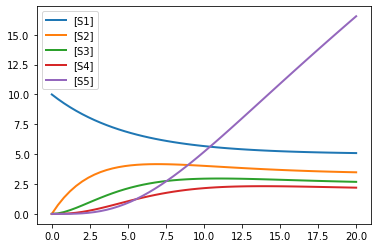

In [11]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1
S2 -> S3; k3*S2
S3 -> S4; k4*S3
S4 -> S5; k5*S4

k1 = 0.1
k2 = 0.2
k3 = 0.3
k4 = 0.4
k5 = 0.5
S0 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
S5 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_RR.plot(LINEAR_RR.simulate(0, 20))

In [5]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
NONLINEAR1_MDL = """
//S0 -> 2 S0; S0
$S0 -> S1; $S0
S1 -> S2; k2*S1
S2 -> ; k3*S2*S1

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR1_RR = te.loada(NONLINEAR1_MDL)
#NONLINEAR1_RR.plot(NONLINEAR1_RR.simulate())

In [6]:
NONLINEAR1_RR.reset()
NONLINEAR1_RR.getFullJacobian()

      S1,  S2
S1 [[ -1,   0],
S2  [  1, -10]]

In [7]:
ctlsb = ControlSBML(NONLINEAR1_MDL)
ctlsb.jacobian

,S0,S1,S2
S0,0.0,0.0,0.0
S1,1.0,-1.0,0.0
S2,0.0,1.0,-10.0


In [8]:
ctlsb = ControlSBML(NONLINEAR1_MDL)
ctlsb.jacobian
ctlsb.jacobian

,S0,S1,S2
S0,0.0,0.0,0.0
S1,1.0,-1.0,0.0
S2,0.0,1.0,-10.0


In [9]:
NONLINEAR1_RR.getBoundarySpeciesIds()

['S0']

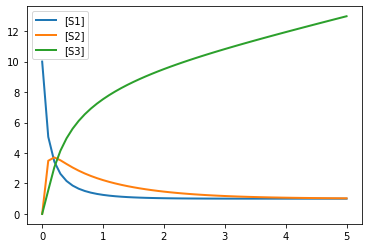

In [10]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
NONLINEAR2_MDL = """
//S0 -> 2 S0; S0
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2*S1

k1 = 0.1
k2 = 0.2
k3 = 0.3
k4 = 0.4
S0 = 0.5
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR2_RR = te.loada(NONLINEAR2_MDL)
NONLINEAR2_RR.plot(NONLINEAR2_RR.simulate())

# Model Reductions

In [12]:
sbctl = ControlSBML(LINEAR_RR)

## Eigenvalues and eigenvectors of the Jacobian

In [58]:
A = sbctl.jacobian
A_mat = A.values
A

,S0,S1,S2,S3,S4,S5
S0,0.0,0.0,0.0,0.0,0.0,0.0
S1,1.0,-0.2,0.0,0.0,0.0,0.0
S2,0.0,0.2,-0.3,0.0,0.0,0.0
S3,0.0,0.0,0.3,-0.4,0.0,0.0
S4,0.0,0.0,0.0,0.4,-0.5,0.0
S5,0.0,0.0,0.0,0.0,0.5,0.0


In [72]:
U, S, V = np.linalg.svd(A_mat)

In [73]:
pd.DataFrame(U)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
1,-0.999000,0.005925,-0.023160,0.034971,-0.014291,0.0
2,0.044355,0.059379,-0.436070,0.817430,-0.368996,0.0
3,-0.005355,-0.338561,0.770352,0.211395,-0.497210,0.0
4,0.001550,0.790072,0.067783,-0.268246,-0.547022,0.0
5,-0.000489,-0.507545,-0.459640,-0.462538,-0.563194,0.0


In [77]:
pd.DataFrame(np.identity(6) * S)

,0,1,2,3,4,5
0,1.020674,0.000000,0.0000,0.000000,0.000000,0.0
1,0.000000,0.799477,0.0000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.5356,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0000,0.324059,0.000000,0.0
4,0.000000,0.000000,0.0000,0.000000,0.084727,0.0
5,0.000000,0.000000,0.0000,0.000000,0.000000,0.0


In [78]:
pd.DataFrame(V)

,0,1,2,3,4,5
0,-0.978765,0.204444,-0.014611,0.002706,-0.000999,-0.0
1,0.007412,0.013372,-0.149325,0.564686,-0.811541,0.0
2,-0.043242,-0.154186,0.675741,-0.524697,-0.492367,0.0
3,0.107915,0.482912,-0.561042,-0.592042,-0.299779,0.0
4,-0.168668,-0.837285,-0.453977,-0.235164,-0.095436,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


## Construct the reduced order model

We'll do this by using a new coordinate space.
This coordinate space eliminates the effects of smaller singular values.

We'll transform ${\bf A}$, and $n \times n$ matrix, to reduce the dimension to $m \times m$.
This is done using singular values.
We'll construct $\tilde{{\bf A}} = {\tilde {\bf U}} {\tilde {\bf S}} {\tilde {\bf V}}$ such that:
* ${\tilde {\bf U}}$ is $n \times m$
* ${\tilde {\bf S}}$ is $m \times m$
* ${\tilde {\bf V}}$ is $m \times n$

In [79]:
np.shape(S)

(6,)

In [110]:
def mkReducedOrderModel(A_mat, r):
    """
    Creates a reduced order model of dimension r.
    
    Parameters
    ----------
    A_mat: n X n matrix
    r: int (r < n)
    
    Returns
    -------
    A_tilde_mat: n X n
    """
    U_mat, S_mat, V_mat = np.linalg.svd(A_mat)
    lst = [v if n < r else 0 for n, v in enumerate(S_mat)]
    S_tilde = np.array(lst)
    df = pd.DataFrame(np.matmul(U * S_tilde, V_mat))
    df = df.applymap(lambda v: v if np.abs(v) > 0.0001 else 0)
    return df.values

# Tests
np.allclose(mkReducedOrderModel(A_mat, 6), A_mat)

True

In [122]:
U_mat, S_mat, V_mat = np.linalg.svd(A_mat)
pd.DataFrame(V_mat)

,0,1,2,3,4,5
0,-0.978765,0.204444,-0.014611,0.002706,-0.000999,-0.0
1,0.007412,0.013372,-0.149325,0.564686,-0.811541,0.0
2,-0.043242,-0.154186,0.675741,-0.524697,-0.492367,0.0
3,0.107915,0.482912,-0.561042,-0.592042,-0.299779,0.0
4,-0.168668,-0.837285,-0.453977,-0.235164,-0.095436,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


Note which species are most weighted for each coordinate.

In [111]:
pd.DataFrame(mkReducedOrderModel(A_mat, 6))

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.2,0.0,0.0,0.0,0.0
2,0.0,0.2,-0.3,0.0,0.0,0.0
3,0.0,0.0,0.3,-0.4,0.0,0.0
4,0.0,0.0,0.0,0.4,-0.5,0.0
5,0.0,0.0,0.0,0.0,0.5,0.0


In [121]:
np.linalg.eig(pd.DataFrame(mkReducedOrderModel(A_mat, 3)))[0]

array([ 0.00000000e+00+0.j        , -5.31951157e-01+0.11337084j,
       -5.31951157e-01-0.11337084j, -2.07991544e-01+0.j        ,
       -5.59849530e-18+0.j        ,  0.00000000e+00+0.j        ])

In [69]:
[np.shape(m) for m in [p_left_mat, A_mat, p_right_mat]]

[(6, 4), (6, 6), (4, 6)]

In [41]:
p_mat_T = np.transpose(p_mat)

In [42]:
red_mat = np.matmul(np.matmul(p_mat, A_mat), p_mat_T)
pd.DataFrame(red_mat)

,0,1,2,3
0,0.0,0.248282,0.175412,6.012505e-292
1,0.0,-0.300000,-0.195982,-4.975985e-292
2,0.0,-0.293973,-0.200000,-5.273316e-292
3,0.0,-0.248282,-0.175412,-6.012505e-292


In [43]:
np.linalg.eig(red_mat)

(array([ 0.00000000e+000, -4.95180091e-001, -4.81990877e-003,
         4.54168194e-292]),
 array([[ 1.00000000e+000,  4.61287540e-001, -8.30990951e-001,
          2.62269844e-001],
        [ 0.00000000e+000, -5.40031803e-001, -2.51646882e-001,
          1.54759940e-291],
        [ 0.00000000e+000, -5.37822780e-001,  3.79020723e-001,
         -4.81912001e-291],
        [ 0.00000000e+000, -4.54231345e-001,  3.20111196e-001,
          9.64994575e-001]]))

**TO DO**
1. Analyze eigenvalues of the reduced matrix
1. What analysis should be done with reduced order systems?
   1. Analysis in new coordinate space of reduced dimension?
   1. Analyze the transformation vectors?

## Accuracy of Linear Model: Sequential Pathway

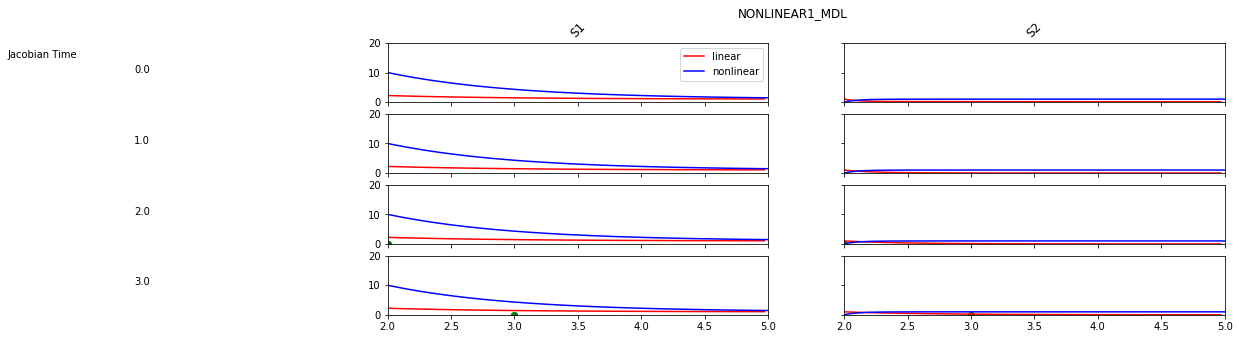

OK!


In [11]:
def evaluateAccuracy(sbml_model, timepoints, suptitle="", is_plot=True, start_time=0, end_time=5, ymax=None, ymin=0):
    if isinstance(timepoints, float) or isinstance(timepoints, int):
        timepoints = [timepoints]
    ctlsb = ControlSBML(sbml_model)
    rr_df = ctlsb.simulateRoadrunner(start_time, end_time)
    nrow = len(timepoints)
    ncol = len(rr_df.columns)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
    axes = np.reshape(axes, (nrow, ncol))
    for irow, timepoint in enumerate(timepoints):
        linear_df = ctlsb.simulateLinearSystem(timepoint=timepoint, start_time=start_time, end_time=end_time)
        if ymax is None:
            ymax_val = max(linear_df.max().max(), rr_df.max().max())
        else:
            ymax_val = ymax
        for icol, column in enumerate(rr_df.columns):
            ax = axes[irow, icol]
            ax.plot(linear_df.index, linear_df[column], color="red")
            ax.plot(rr_df.index, rr_df[column], color="blue")
            ax.scatter([timepoint], [ymin], s=40, marker="o", color="g")
            ax.set_xlim([start_time, end_time])
            ax.set_ylim([0, ymax_val])
            if irow < nrow - 1:
                ax.set_xticklabels([])
            if irow == 0:
                ax.set_title(column, rotation=45)
                if icol == 0:
                    ax.text(start_time-3, 0.75*ymax_val, "Jacobian Time")
                    ax.legend(["linear", "nonlinear"])
            if icol > 0:
                ax.set_yticklabels([])
            else:
                ax.text(start_time-2, ymax_val/2, "%2.1f" % timepoint)
    plt.suptitle(suptitle)
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
suptitle = "NONLINEAR1_MDL"
evaluateAccuracy(NONLINEAR1_MDL, [0, 1, 2, 3], suptitle=suptitle, start_time=2, ymax=20,  is_plot=True)
print("OK!")

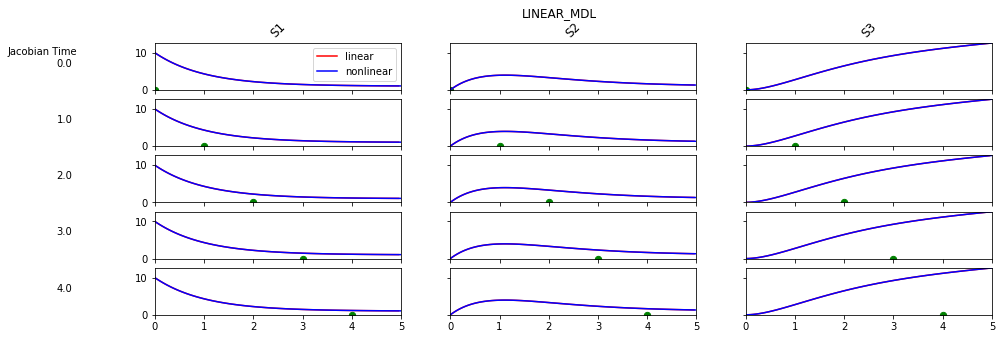

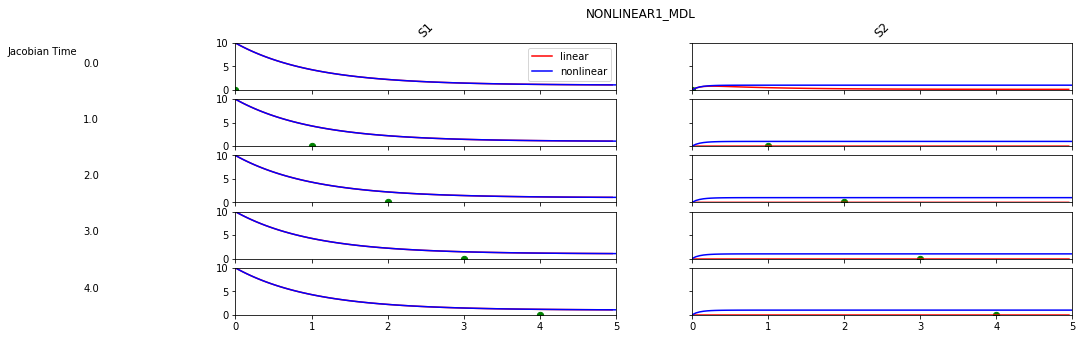

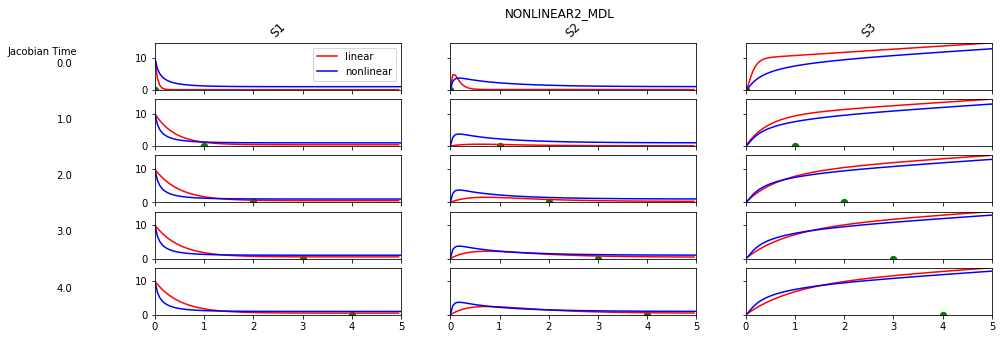

In [12]:
timepoints = range(5)
for name in ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]:
    mdl = eval(name)
    evaluateAccuracy(mdl, timepoints, suptitle=name, is_plot=True)

In [13]:
try:
    symmath = SymmathSBML(NONLINEAR2_MDL)
    symmath.jacobian_df
except:
    pass

**Notes**
1. For S0, the time at which the Jacobian is calculated doesn't matter since $\frac {\partial S_0}{S_n}$ is a constant (0).
1. $S_1$, $S_2$, $S_3$ have non-constant partial derivatives and so their Jacobian will change with the timepoint.

In [14]:
for mdl in MODELS:
    print("\n\n %s" % mdl)
    symmath = SymmathSBML(eval(mdl))
    print(symmath.getJacobian(is_sub_parameters=True, is_sub_others=True, is_sub_species=False))



 LINEAR_MDL
                  S0                 S1                 S2 S3
S0                 0                  0                  0  0
S1  1.00000000000000  -1.00000000000000                  0  0
S2                 0   1.00000000000000  -1.00000000000000  0
S3                 0                  0   1.00000000000000  0


 NONLINEAR1_MDL
                  S0                 S1       S2
S0                 0                  0        0
S1  1.00000000000000  -1.00000000000000        0
S2                 0       1.0 - 1.0*S2  -1.0*S1


 NONLINEAR2_MDL
                  S0               S1       S2 S3
S0                 0                0        0  0
S1  1.00000000000000          -2.0*S1        0  0
S2                 0  2.0*S1 - 1.0*S2  -1.0*S1  0
S3                 0           1.0*S2   1.0*S1  0


# Controllability

In [15]:
B = np.array([1, 0, 0])
B = np.reshape(B, (3, 1))
B

array([[1],
       [0],
       [0]])

## Issues
1. Many models wouldn't load in symmathSBML
1. Seems that state includes some elements that are not species, BCK2
1. Why is there a difference between the length of the state_vec and the length of species_names?
1. Need getCurrentState

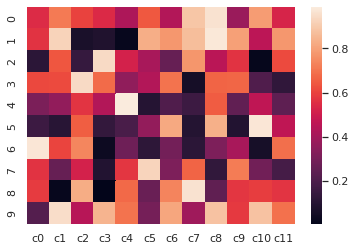

In [16]:
import numpy as np; np.random.seed(0)
import pandas as pd
import seaborn as sns; sns.set_theme()
ncol = 12
uniform_data = np.random.rand(10, ncol)
columns = ["c%d" % n for n in range(ncol)]
df = pd.DataFrame(uniform_data, columns=columns)
ax = sns.heatmap(df)


# Wolf Model

In [17]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml")

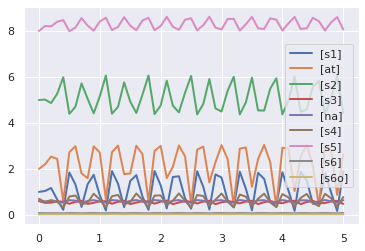

In [18]:
rr.plot(rr.simulate())

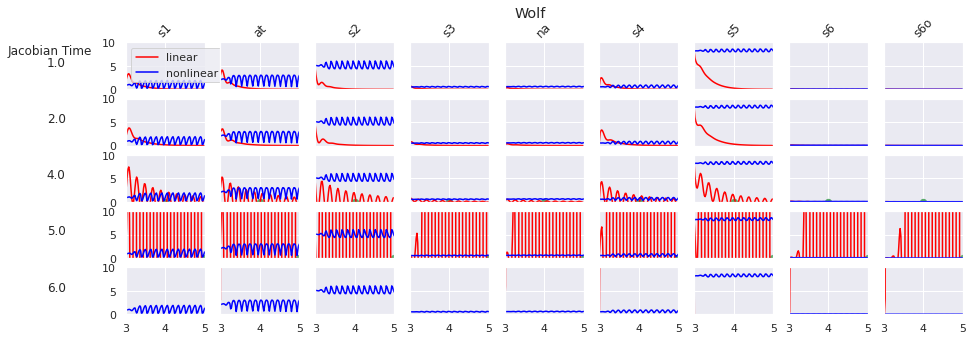

In [19]:
evaluateAccuracy(rr, [1, 2, 4, 5, 6], suptitle="Wolf", start_time=3, end_time=5, ymax=10)

# Model 193

In [20]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000193.2?filename=BIOMD0000000193_url.xml")

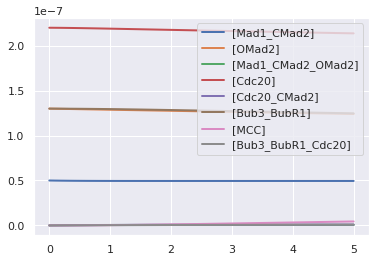

In [21]:
rr.plot(rr.simulate())

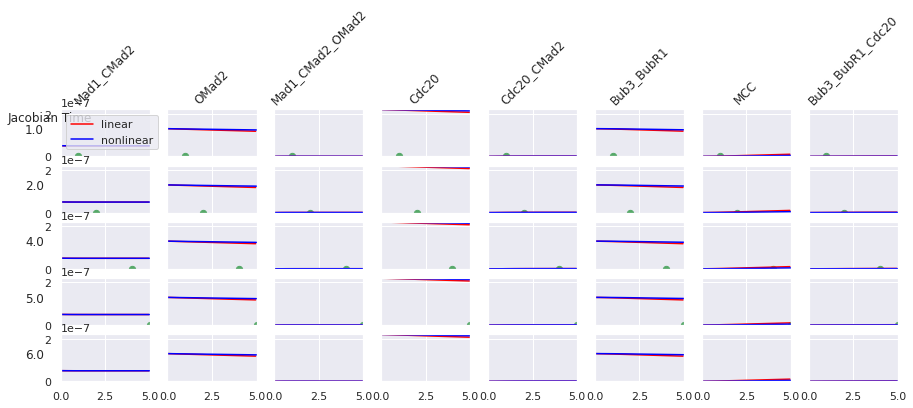

In [22]:
evaluateAccuracy(rr, [1, 2, 4, 5, 6], end_time=5)

# Model 816

In [23]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000816.5?filename=model.xml")

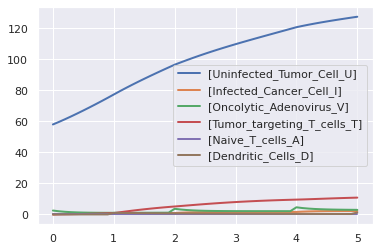

In [24]:
rr.plot(rr.simulate())

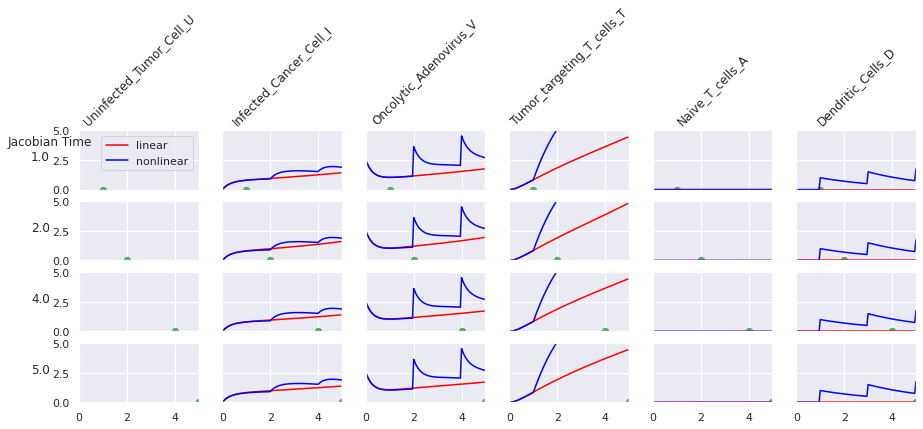

In [25]:
evaluateAccuracy(rr, [1, 2, 4, 5], end_time=5, ymax=5)

# Model 823

In [26]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml")

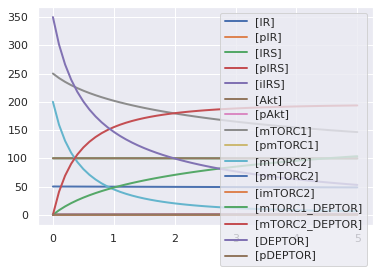

In [27]:
rr.plot(rr.simulate())

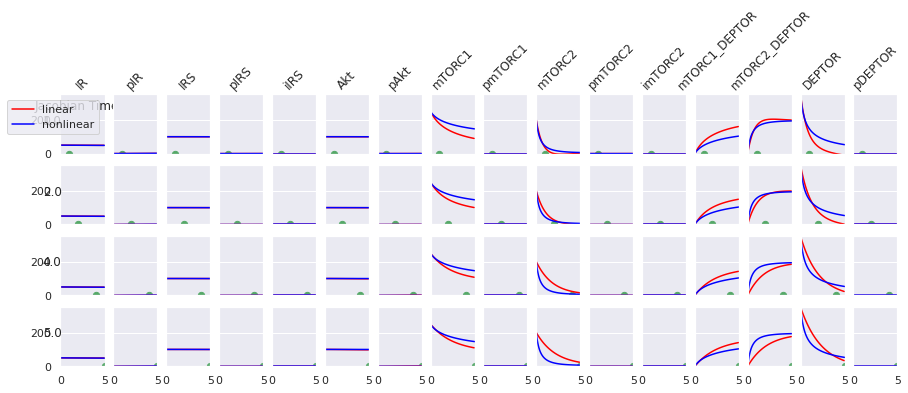

In [28]:
evaluateAccuracy(rr, [1, 2, 4, 5], end_time=5)